In [1]:
from modules.data_types import Transmission
from modules.utils import pad_arrays
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from scipy.signal import peak_widths
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.gridspec import GridSpec
from itertools import product
import matplotlib.ticker as ticker
from string import ascii_uppercase
fontprops = fm.FontProperties(size=18)

In [2]:
from scipy.stats import zscore

In [3]:
t = Transmission.from_hdf5('./data/kshape_data_small.ptrn')

In [4]:
t.df = t.df[t.df.KSHAPE_CLUSTER != 7]

## Fig 5a

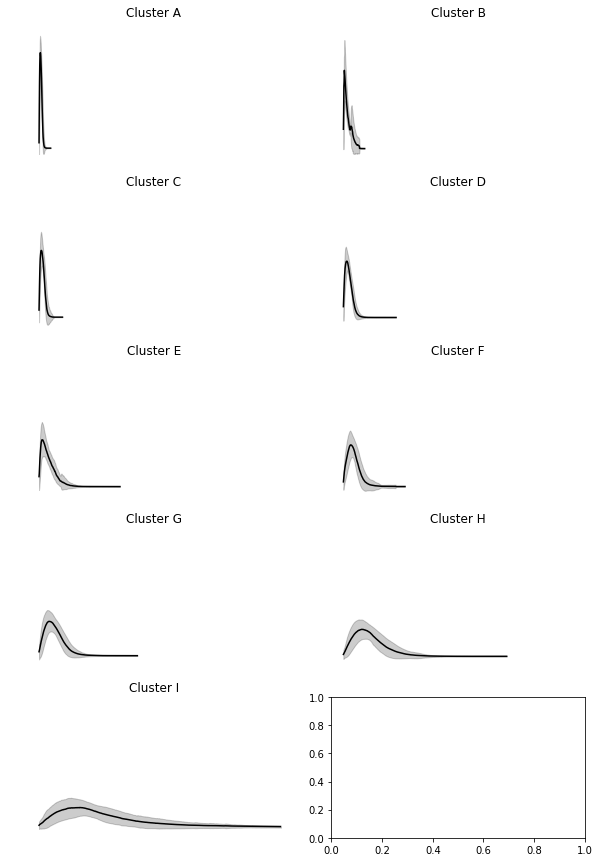

In [5]:
clusters = t.df.KSHAPE_CLUSTER.unique()
data = t.df._pf_peak_curve.values
padded = pad_arrays(data, method='fill-size')
# scaled = TimeSeriesScalerMeanVariance().fit_transform(padded)[:, :, 0]
# scaled = StandardScaler().fit_transform(padded)
scaled = zscore(padded, axis=1)
mean_widths = {}

for c_ix in clusters:
    ys = scaled[t.df.KSHAPE_CLUSTER.values == c_ix]
    xs = []
    for y in ys:
        xs.append(np.arange(y.size))
    xsh = np.hstack(xs)
    ysh = np.hstack(ys)
#     sns.lineplot(x=xsh, y=ysh, ci='sd')#, estimator=None)
    mean_peak = np.mean(ys, axis=0)
    width = peak_widths(mean_peak, peaks=[np.argmax(mean_peak)], rel_height=0.5)[0][0]
    mean_widths[width] = c_ix

nrows = 5
ncols = 2
    
fig = plt.figure(figsize=(2*5, 3*5))
axs = fig.subplots(nrows, ncols)

sort_ixs = sorted(mean_widths.keys())

axs_ixs = tuple(product(range(nrows), range(ncols)))

alphabets = list(ascii_uppercase)[:len(sort_ixs)]

cluster_alphabet_mapping = {}

for alphabet, sort_ix, axs_ix in zip(alphabets, sort_ixs, axs_ixs):
    c_ix = mean_widths[sort_ix]
    
    cluster_alphabet_mapping[c_ix] = alphabet
    
    ax = axs[axs_ix]
    
    cluster_members = scaled[t.df.KSHAPE_CLUSTER.values == c_ix]
    
    mean_curve = cluster_members.mean(axis=0)
    
    ys = cluster_members[:, :np.argmin(mean_curve)]
    
    stdev = ys.std(axis=0)
    
    xs = []
    for y in ys:
        xs.append(np.arange(y.size))
    xsh = np.hstack(xs)
    ysh = np.hstack(ys)
    
    sns.lineplot(x=xsh, y=ysh, ci='sd', color='k', ax=ax)
    ax.set_title(f"Cluster {cluster_alphabet_mapping[c_ix]}")#", stdev @ maxima: {stdev[np.argmax(ys.mean(axis=0))].mean():.2f}, width: {np.argmax(ys.mean(axis=0))}")
    ax.set_ylim([-2, 16])
    ax.set_xlim([-50, 1000])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
#     ax.set_xticklabels(np.arange(0, padded.shape[1], 10))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.axis('off')
plt.show()

In [6]:
fig.savefig('./figs/kshape_means_without_axes.png', dpi=1200)